# Time variant filtering

In contrast to the (linear) time invariant filter, (linear) time variant filter assumes that the filter coefficients are changing across time.

Consider the most general case where there is one filter for each time step $n\in\{1, \cdots, N\}$. Given an input sequence $x_{1:N}=\{x_1, \cdots, x_N\}$ and a sequence of filters $\{\{h_{0,1}, h_{1,1}, h_{K-1,1}\}, \{h_{0,1}, h_{1,2}, h_{K-1,2}\}, \cdots, \{h_{0,N}, h_{1,N}, h_{K-1,N}\}\}$, the output $y_n$ at the $n$-th time step can be computed as

$y_n = \sum_{k=0}^{K-1} h_{k,\color{red}{n}}x_{n-k}= h_{0,\color{red}{n}}x_{n} + h_{1,\color{red}{n}}x_{n-1} + \cdots + h_{K-1,\color{red}{n}}x_{n-({K-1})}$

Figure below shows an example of time-variant filtering on input signal $\{x_1, x_2, x_3, x_4\}$ with filters $\{\{h_{0,1}, h_{1,1}, h_{2,1}\}, \{h_{0,1}, h_{1,2}, h_{2,2}\}, \{h_{0,3}, h_{1,3}, h_{2,3}\}, \{h_{0,4}, h_{1,4}, h_{2,4}\}\}$. Notice how the filters of different time steps are applied on the signals.

![Images_2](./figures/fig_c7_1.png)

The implemented time variant filtering is similar to the example above. Before explaining the details, let's first explain the behavior of the wrapper:
1. Input tensor has shape (batchsize, length, dim)
2. Input filter coefficients is in shape (batchsize, length, filter_order)
3. Output tensor has shape (batchsize, length, dim)

Note that the filter coefficients tensor has a leading dimension that correspond to batch size. 
Suppose input tensor is in shape (batchsize=B, length, dim=N) and filter tensor is in shape (B, length, order=K),  the wrapper conducts filter for each batch independently. 

The N dimensions are treated as N 1-D signals, and they are independently processed to produce N output signals.

### 1. Module definition

Here is a simple implementation, which corresponds to the intuitive example above. 

![Images_1](./figures/fig_c7_2.png)

The operations include element-wise multiplication $\odot$, circular shift, and summation.

It conduct filtering of all time steps in parallel. However, it uses a *for loop* to do the summation.

In [1]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class TimeVariantFiltering(torch_nn.Module):
    """ TimeVariantFiltering
    Given sequences of filter coefficients and a signal, do filtering
    
    Initialization: TimeVariantFiltering()
    Forward: output = forward(self, signal, filter_coef)
    
        Filter_coefs: (batchsize, signal_length, filter_order = K)
        
                      (n, m, :) is the filter coefficients for the m-th 
                      time step for n-th tensor in the batch
                      
        Signal:       (batchsize, signal_length, dim)
        
        Output:       (batchsize, signal_length, dim)
    
    
    Filtering is conducted for d \in [0, dim), assuming they use the same 
    time-variant filter.
    
    For time invariant case, given signal [x_1, ..., x_N], filter [a_1, ..., a_K]
    we get output 
                    [y_1, y_2, y_3, ..., y_N, *, * ... *]
            = a_1 * [x_1, x_2, x_3, ..., x_N,   0, ...,   0]
            + a_2 * [  0, x_1, x_2, x_3, ..., x_N,   0, ...,  0]
            + a_3 * [  0,   0, x_1, x_2, x_3, ..., x_N, 0, ...,  0]
            + ...
    
    For time variant casse, given signal [x_1, ..., x_N], filter matrix 
    [[a_{1,1}, ..., a_{K,1}], [a_{1,2}, ..., a_{K,2}], ...], we get output
    
                    y_1,                 y_2,              y_3,    
            = a_{1,1} * x_1  = a_{1,2} * x_2   = a_{1,3} * x_3
            + a_{2,1} *   0  + a_{2,2} * x_1   + a_{2,3} * x_2
            + a_{3,1} *   0  + a_{3,2} *   0   + a_{3,3} * x_1
            + ...            + ...             + ...
    
    """
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()
    
    def forward(self, signal, f_coef):
        """ 
        """
        # signal length
        signal_l = signal.shape[1]
        # order of the time varint filter
        order_k = f_coef.shape[-1]
        
        # pad to signal (batchsize, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
        
        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1] 
        return output
    

### 2. Simple example

Here is the example in the two figures above.

In [2]:
# input signal
# make it a batch (batchsize=1, length=4, dim=1)
data = torch.arange(1.0, 5.0, 1).unsqueeze(0).unsqueeze(2)

# filter coefficients
# make it a batch (batchsize=1, length=4, order=3)
coef = [[1, -0.5, -0.5], [1, -0.9, 0], [1, 0, -0.5], [0.3, 0.3, 0.3]]
coef = torch.tensor(coef).unsqueeze(0)

# signal length
signal_l = data.shape[1]
# order of the time varint filter
order_k = coef.shape[-1]

# do filter
l_tv_filter = TimeVariantFiltering()
output = l_tv_filter(data, coef)


(<Figure size 144x36 with 1 Axes>,
 [<matplotlib.axes._axes.Axes at 0x7ffca3615490>])

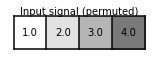

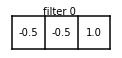

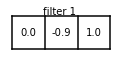

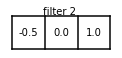

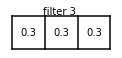

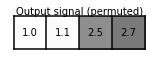

In [3]:
import plot_lib
plot_lib.plot_tensor(data.permute(0, 2, 1), color_on_value=True, title="Input signal (permuted)")

# for plotting we flip the filter coefficients
for time_idx in range(coef.shape[1]):
    plot_lib.plot_tensor(torch.flip(coef[:, time_idx:time_idx+1, ], dims=[2]), 
                         color_on_value=False, colorgrad_x=False, colorgrad_y=False,
                         colormap="Greys", alpha=1.0, title = 'filter %d ' % (time_idx))

plot_lib.plot_tensor(output.permute(0, 2, 1), color_on_value=True, title="Output signal (permuted)")

### 3. Plot the operation step by step
Here we plot the operation in the Module step by step

In [4]:
# signal length
signal_l = data.shape[1]
# order of the time varint filter
order_k = coef.shape[-1]
signal = data

# step1. padding:
# pad to signal (batchsize, signal_length + filter_order-1, dim)
padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
#plot_lib.plot_tensor(signal, color_on_value=True, title="Input signal")
#plot_lib.plot_tensor(padded_signal, color_on_value=True, title="Padded")

#plot_lib.plot_tensor(coef, color_on_value=False, colorgrad_x=False, colorgrad_y=False, title="Filter coefs")

# step2. circular shift and weighted sum
output = torch.zeros_like(signal)
for k in range(order_k):
    output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] * coef[:, :, k:k+1] 
    #plot_lib.plot_tensor(torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :], color_on_value=True)
    #plot_lib.plot_tensor(coef[:, :, k:k+1], color_on_value=False, colorgrad_x=False, colorgrad_y=False)
#plot_lib.plot_tensor(output, color_on_value=True, title="output")


### 4. Example for signal processing

This is the example of using time-variant filtering to process random signals.

First, we create a tensor to store the time variant filter coefficients. Notice that we use different filter coefficients *lp_v*, *hp_v*, and *hp_u*.
```
tv_filter_coefs[:, signal_length//4*0:signal_length//4*1, 0:len(lp_v)] = lp_v
tv_filter_coefs[:, signal_length//4*1:signal_length//4*3, 0:len(hp_v)] = hp_v
tv_filter_coefs[:, signal_length//4*3:, 0:len(hp_u)] = hp_u
```

In [5]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Prepare input signal
signal_length = 1000
signal_dim = 2
batch_size = 2

signal_input = torch.randn(batch_size, signal_length, signal_dim, requires_grad = False)


# Prepare a time-variant filter based on the following filter coefficients
# The filter coefficients should be in shape [batch_size, signal_length, filter_order]
# In this example, different batches use the same filter coefs 
lp_v = torch.tensor([0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068])
lp_u = torch.tensor([0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502])
hp_v = torch.tensor([-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148])
hp_u = torch.tensor([0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929])

# initialize buffer for tv-filter coefficients
tv_filter_coefs = torch.zeros(batch_size, signal_length, max([len(lp_v), len(lp_u), len(hp_v), len(hp_u)]))

# fill in the values
tv_filter_coefs[:, signal_length//4*0:signal_length//4*1, 0:len(lp_v)] = lp_v
tv_filter_coefs[:, signal_length//4*1:signal_length//4*3, 0:len(hp_v)] = hp_v
tv_filter_coefs[:, signal_length//4*3:, 0:len(hp_u)] = hp_u


(2049.0, 0.0)

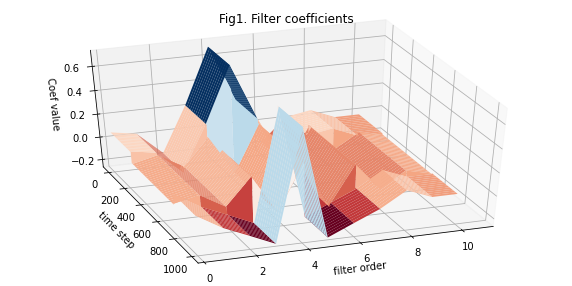

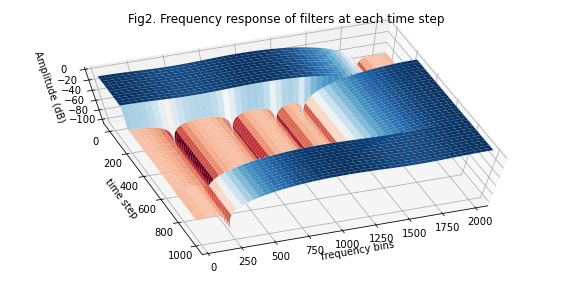

In [6]:

# plot the filter coefficients (only (0, :, :))
plot_batch = 0

fig = plt.figure()
ax = fig.gca(projection='3d')
import importlib
importlib.reload(plot_lib)
plot_lib.plot_surface(tv_filter_coefs[plot_batch].numpy().T, fig, ax, 
                      ylabel='time step', xlabel='filter order', zlabel='Coef value', 
                      angleX=40, angleY=70)
ax.set_title("Fig1. Filter coefficients")
ax.set_xlim(tv_filter_coefs.shape[2], 0)

# plot the frequency response of filters for each time step (this may take some time)
# for simplicity, just plot the three sets of cofficients
def get_amp_(data):
    return 20*np.log10(np.abs(data) + np.finfo(np.float32).eps)

nfft=4096
w, h_lp_v = scipy.signal.freqz(lp_v, [1], worN=nfft, whole=True)
w, h_hp_v = scipy.signal.freqz(hp_v, [1], worN=nfft, whole=True)
w, h_hp_u = scipy.signal.freqz(hp_u, [1], worN=nfft, whole=True)
filter_res = np.zeros([tv_filter_coefs.shape[1], nfft//2+1])
filter_res[signal_length//4*0:signal_length//4*1, :] = get_amp_(h_lp_v[0:nfft//2+1])
filter_res[signal_length//4*1:signal_length//4*3, :] = get_amp_(h_hp_v[0:nfft//2+1])
filter_res[signal_length//4*3:, :] = get_amp_(h_hp_u[0:nfft//2+1])

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(filter_res.T, fig, ax, 
                      ylabel='time step', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig2. Frequency response of filters at each time step")
ax.set_xlim(nfft//2+1, 0)

As Fig.2 shows, the frequency response at time step.

We will use this time variant filter to process the random signals.

In [7]:
tv_layer = TimeVariantFiltering()
signal_output = tv_layer(signal_input, tv_filter_coefs)

Now, let's plot the spectral of the input and output signals.

(2049.0, 0.0)

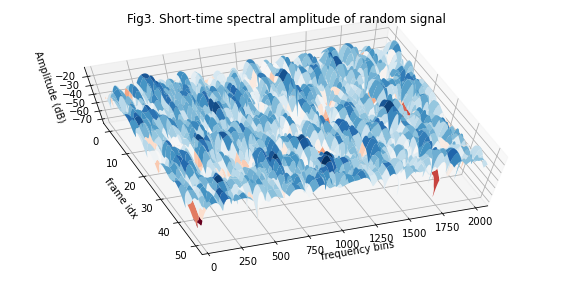

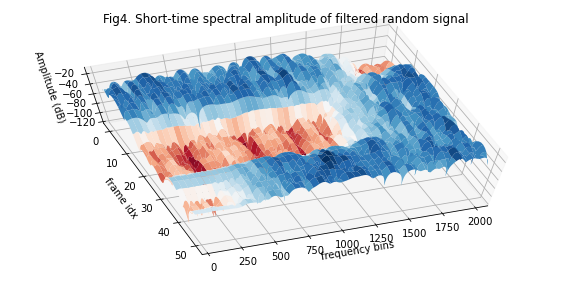

In [8]:
# Plot 
# let's try to plot the spectrogram
# let's analysis only one signal
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_examine = signal_output[0, :, 0]

nfft=4096
spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20, fft_bins=nfft)
spec_out_examine = tool_lib.spec_amplitude(signal_out_examine, frame_length=200, frame_shift=20, fft_bins=nfft)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_in_examine, fig, ax, 
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig3. Short-time spectral amplitude of random signal")
ax.set_xlim(nfft//2+1, 0)

fig = plt.figure()
ax = fig.gca(projection='3d')
plot_lib.plot_surface(spec_out_examine, fig, ax, 
                      ylabel='frame idx', xlabel='frequency bins', zlabel='Amplitude (dB)',
                      angleX=70, angleY=70)
ax.set_title("Fig4. Short-time spectral amplitude of filtered random signal")
ax.set_xlim(nfft//2+1, 0)

From the above figure, we can see how the spectral of the random noise is shaped by the time-variant filters. 

The spectral shape in Fig4 is decided by the spectral shape of filters in Fig2.

# 5. Summary

This notebook defines the time variant filtering wrapper:
1. Input tensor has shape (batchsize, length, dim)
2. Input filter coefficients is in shape (batchsize, length, filter_order)
3. Output tensor has shape (batchsize, length, dim)

This time variant filtering wrapper will be used in the next notebook for time variant windowed sinc filters.